In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

                                                                      
np.random.seed(42)
torch.manual_seed(42)

                                                
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [2]:
data= pd.read_csv('train.csv')
data.info()
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41348 entries, 0 to 41347
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   neighbourhood_group  40509 non-null  object 
 1   room_type            40737 non-null  object 
 2   minimum_nights       40026 non-null  float64
 3   amenity_score        40432 non-null  float64
 4   number_of_reviews    40225 non-null  float64
 5   availability_365     40753 non-null  float64
 6   price_class          41348 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 2.2+ MB
  neighbourhood_group        room_type  minimum_nights  amenity_score  \
0           Manhattan              NaN             2.0           82.5   
1           Manhattan     Private room             2.0           53.7   
2            Brooklyn     Private room             2.0           47.8   
3           Manhattan  Entire home/apt             2.0           58.8   
4              

In [3]:
null_counts = data.isna().sum()
print("Null counts per column:\n", null_counts)
print("Total nulls:", null_counts.sum())

                                   
print("Columns with nulls:\n", null_counts[null_counts > 0])

Null counts per column:
 neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64
Total nulls: 5406
Columns with nulls:
 neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
dtype: int64


In [4]:

print("Shape:", data.shape)
print("\nDtypes:\n", data.dtypes)
print("\nMissing per column:\n", data.isna().sum())

display(data.describe())

cat_cols = data.select_dtypes(include=["object"]).columns
for c in cat_cols:
    print(f"\n{c} value counts:\n", data[c].value_counts(dropna=False).head(10))

print("\nprice_class distribution:\n", data["price_class"].value_counts())

display(data.select_dtypes(include=["number"]).corr())

Shape: (41348, 7)

Dtypes:
 neighbourhood_group     object
room_type               object
minimum_nights         float64
amenity_score          float64
number_of_reviews      float64
availability_365       float64
price_class              int64
dtype: object

Missing per column:
 neighbourhood_group     839
room_type               611
minimum_nights         1322
amenity_score           916
number_of_reviews      1123
availability_365        595
price_class               0
dtype: int64


,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
count,40026.000000,40432.000000,40225.000000,40753.000000,41348.000000
mean,7.002873,51.987233,23.648154,111.912178,1.231619
std,19.725353,19.459480,44.518303,131.273916,0.758579
min,1.000000,10.000000,0.000000,0.000000,0.000000
25%,1.000000,36.800000,1.000000,0.000000,1.000000
50%,3.000000,51.400000,5.000000,44.000000,1.000000
75%,5.000000,66.100000,24.000000,224.000000,2.000000
max,1000.000000,99.000000,607.000000,365.000000,3.000000



neighbourhood_group value counts:
 neighbourhood_group
Manhattan        17905
Brooklyn         16692
Queens            4696
Bronx              907
NaN                839
Staten Island      309
Name: count, dtype: int64

room_type value counts:
 room_type
Entire home/apt    21099
Private room       18663
Shared room          975
NaN                  611
Name: count, dtype: int64

price_class distribution:
 price_class
1    23287
2     9844
0     5567
3     2650
Name: count, dtype: int64


,minimum_nights,amenity_score,number_of_reviews,availability_365,price_class
minimum_nights,1.000000,0.023231,-0.084337,0.140268,0.015818
amenity_score,0.023231,1.000000,-0.030326,0.081418,0.875322
number_of_reviews,-0.084337,-0.030326,1.000000,0.173839,-0.034141
availability_365,0.140268,0.081418,0.173839,1.000000,0.096385
price_class,0.015818,0.875322,-0.034141,0.096385,1.000000


In [5]:
ng_mode = data["neighbourhood_group"].mode().iat[0]
data["neighbourhood_group"] = data["neighbourhood_group"].fillna(ng_mode)

        
print(data["neighbourhood_group"].isna().sum())

0


In [6]:
 
                                                                               
mode_by_class = (
    data.groupby("price_class")["room_type"].agg(lambda s: s.mode().iat[0] if not s.mode().empty else np.nan)
)

overall_mode = data["room_type"].mode().iat[0]

def fill_room_type(row):
    if pd.isna(row["room_type"]):
        return mode_by_class.get(row["price_class"], overall_mode) or overall_mode
    return row["room_type"]

data["room_type"] = data.apply(fill_room_type, axis=1)

        
print("room_type missing after fill:", data["room_type"].isna().sum())

room_type missing after fill: 0


In [7]:
num_cols = data.select_dtypes(include=["number"]).columns
data[num_cols] = data[num_cols].apply(lambda s: s.fillna(s.median()))

        
print("Numeric missing after fill:\n", data[num_cols].isna().sum())

Numeric missing after fill:
 minimum_nights       0
amenity_score        0
number_of_reviews    0
availability_365     0
price_class          0
dtype: int64


Class counts:
 price_class
1    23287
2     9844
0     5567
3     2650
Name: count, dtype: int64

Class percentages (%):
 price_class
1    56.32
2    23.81
0    13.46
3     6.41
Name: proportion, dtype: float64


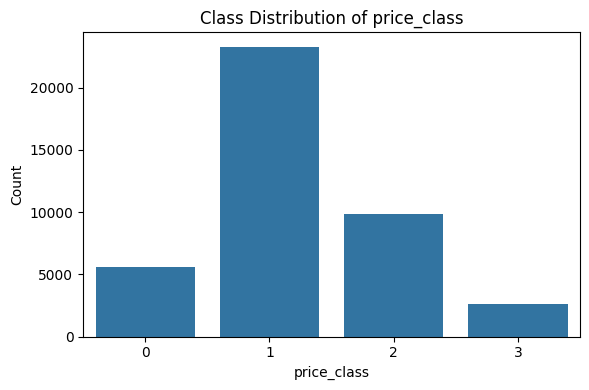

In [8]:
class_counts = data["price_class"].value_counts()
class_perc = data["price_class"].value_counts(normalize=True) * 100

print("Class counts:\n", class_counts)
print("\nClass percentages (%):\n", class_perc.round(2))

plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class Distribution of price_class")
plt.xlabel("price_class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [9]:
 
                                                                    
cat_cols = data.select_dtypes(include=["object"]).columns
data_encoded = pd.get_dummies(data, columns=cat_cols, drop_first=False)

print("Encoded shape:", data_encoded.shape)

Encoded shape: (41348, 13)


In [10]:
print(data_encoded.head())

   minimum_nights  amenity_score  number_of_reviews  availability_365  \
0             2.0           82.5               15.0             254.0   
1             2.0           53.7                1.0               0.0   
2             2.0           47.8               70.0              90.0   
3             2.0           58.8                1.0              44.0   
4             2.0           32.2                0.0              89.0   

   price_class  neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0            3                      False                         False   
1            1                      False                         False   
2            1                      False                          True   
3            1                      False                         False   
4            1                       True                         False   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                           True              

In [11]:
from sklearn.preprocessing import StandardScaler

                                             
num_cols = data_encoded.select_dtypes(include=["number"]).columns
num_cols = [c for c in num_cols if c != "price_class"]

scaler = StandardScaler()
data_encoded[num_cols] = scaler.fit_transform(data_encoded[num_cols])

print("Normalized numeric features with StandardScaler.")

Normalized numeric features with StandardScaler.


In [12]:
num_cols_check = data_encoded.select_dtypes(include=["number"]).columns
num_cols_check = [c for c in num_cols_check if c != "price_class"]

means = data_encoded[num_cols_check].mean()
stds  = data_encoded[num_cols_check].std()

print("Mean of each numeric feature (should be ≈ 0):")
print(means.round(6))
print(f"\nOverall mean: {means.mean():.6f}")

print("\nStd of each numeric feature (should be ≈ 1):")
print(stds.round(6))
print(f"\nOverall std: {stds.mean():.6f}")

Mean of each numeric feature (should be ≈ 0):
minimum_nights      -0.0
amenity_score        0.0
number_of_reviews   -0.0
availability_365    -0.0
dtype: float64

Overall mean: 0.000000

Std of each numeric feature (should be ≈ 1):
minimum_nights       1.000012
amenity_score        1.000012
number_of_reviews    1.000012
availability_365     1.000012
dtype: float64

Overall std: 1.000012


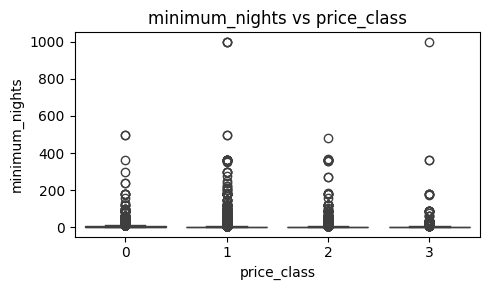

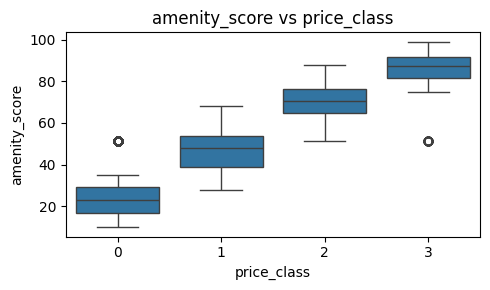

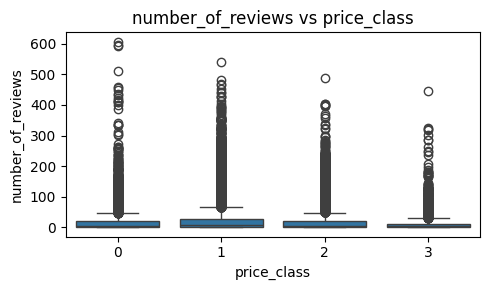

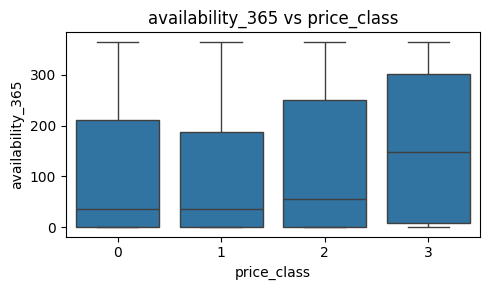

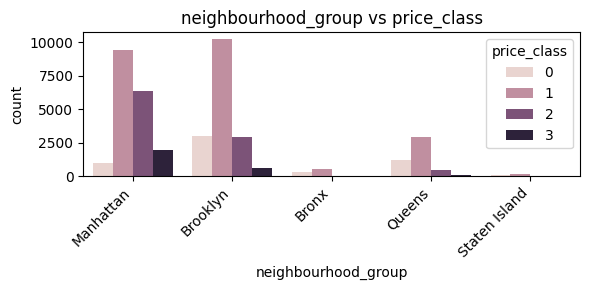

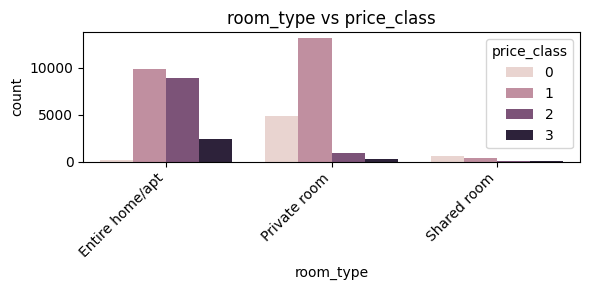

In [13]:
                                                   
num_cols = data.select_dtypes(include=["number"]).columns
num_cols = [c for c in num_cols if c != "price_class"]

for c in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x="price_class", y=c, data=data)
    plt.title(f"{c} vs price_class")
    plt.tight_layout()
    plt.show()

                                     
cat_cols = data.select_dtypes(include=["object"]).columns
for c in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(x=c, hue="price_class", data=data)
    plt.title(f"{c} vs price_class")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

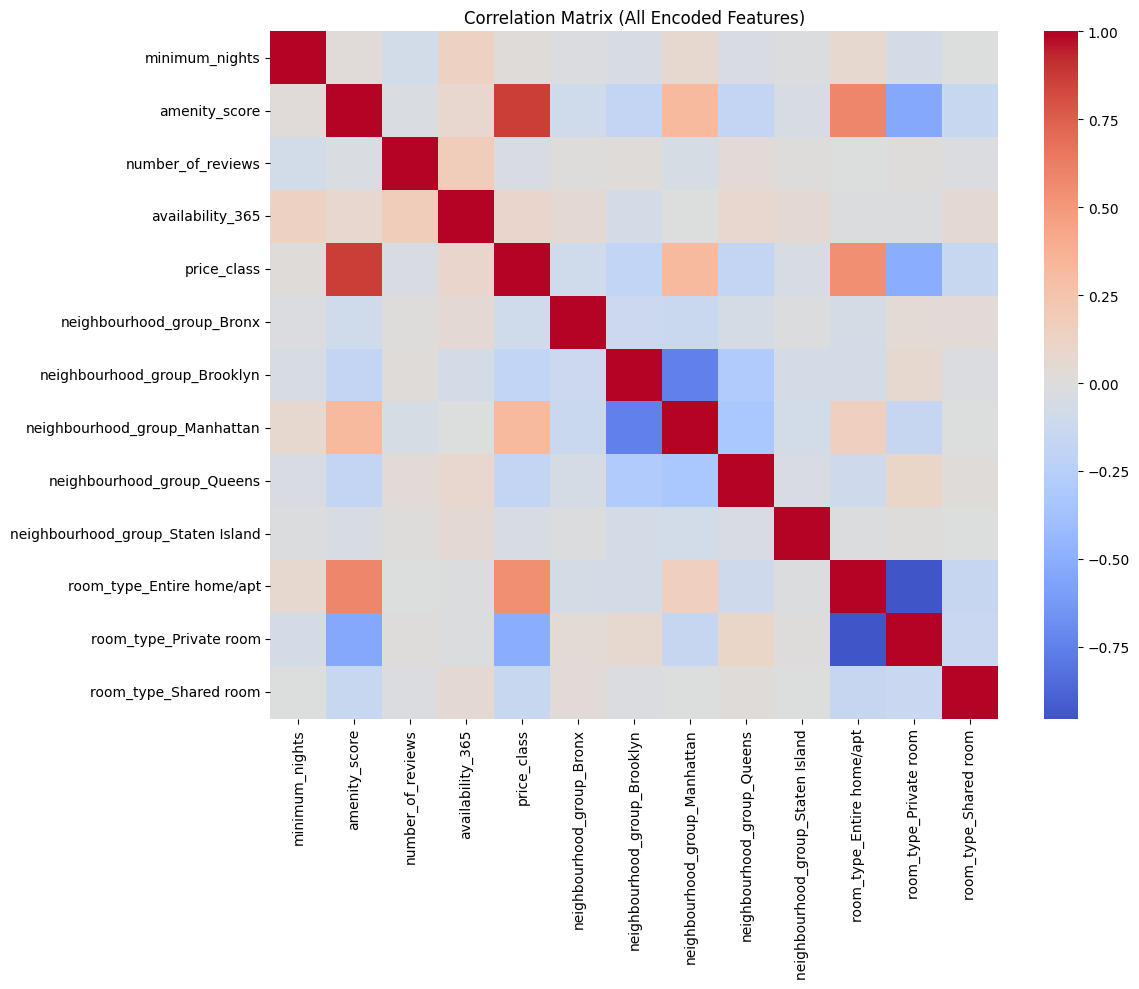

In [14]:
 
                                             
corr_all = data_encoded.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_all, cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Matrix (All Encoded Features)")
plt.tight_layout()
plt.show()

# Part B (a): Two-Layer Perceptron from Scratch (NumPy Only)

A feedforward neural network with **two hidden layers**, implemented using only NumPy.  
No automatic differentiation is used — all gradients are computed manually via the chain rule.

In [15]:
import numpy as np

                                            
                                       
                                            
def sigmoid(z):
                                 
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)                                                     

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)

def softmax(z):
                                          
    e_z = np.exp(z - np.max(z, axis=0, keepdims=True))
    return e_z / np.sum(e_z, axis=0, keepdims=True)

In [16]:
                                            
                           
                                            
def initialize_parameters(M0, M1, M2, M3):
    """
    M0: Input features (Size of X^(0))
    M1: Hidden Layer 1 size
    M2: Hidden Layer 2 size
    M3: Output Layer size (Classes)
    """
    np.random.seed(42)
    params = {}
    
                                                          
                                                 
    params['W1'] = np.random.randn(M1, M0) * 0.1
    params['b1'] = np.zeros((M1, 1))
    
    params['W2'] = np.random.randn(M2, M1) * 0.1
    params['b2'] = np.zeros((M2, 1))
    
    params['W3'] = np.random.randn(M3, M2) * 0.1
    params['b3'] = np.zeros((M3, 1))
    
    return params

In [17]:
                                            
                              
                                            
def forward_pass(X, params, activation_fn):
    """
    X: Input matrix of shape (Features M, Batch Size N)
    Matches algorithm on page 5 of notes.
    """
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    W3, b3 = params['W3'], params['b3']
    
    cache = {}
    cache['X0'] = X
    
             
    cache['A1'] = np.dot(W1, cache['X0']) + b1                              
    cache['X1'] = activation_fn(cache['A1'])                      
    
             
    cache['A2'] = np.dot(W2, cache['X1']) + b2                              
    cache['X2'] = activation_fn(cache['A2'])                      
    
                            
    cache['A3'] = np.dot(W3, cache['X2']) + b3                              
    cache['X3'] = softmax(cache['A3'])                            
    
    return cache['X3'], cache

In [18]:
                                            
                       
                                            
def compute_loss(Y_hat, Y):
    """
    Y_hat: Predicted probabilities (Classes K, Batch Size N)
    Y: True labels, one-hot encoded (Classes K, Batch Size N)
    """
    N = Y.shape[1]
                                   
    loss = -np.sum(Y * np.log(Y_hat + 1e-9)) / N
    return loss

In [19]:
                                            
                                    
                                            
def backward_pass(Y, params, cache, activation_derivative):
    """
    Matches the recursive algorithm on page 17 of notes.
    delta^(l) represents dL / dA^(l)
    """
    N = Y.shape[1]
    grads = {}
    
    W2 = params['W2']
    W3 = params['W3']
    
                          
                                                                  
    delta3 = cache['X3'] - Y  
    
                                                            
    grads['dW3'] = np.dot(delta3, cache['X2'].T) / N                       
    grads['db3'] = np.sum(delta3, axis=1, keepdims=True) / N
    
                            
                                                                 
    delta2 = np.dot(W3.T, delta3) * activation_derivative(cache['A2'])
    
    grads['dW2'] = np.dot(delta2, cache['X1'].T) / N
    grads['db2'] = np.sum(delta2, axis=1, keepdims=True) / N
    
                            
                                                                 
    delta1 = np.dot(W2.T, delta2) * activation_derivative(cache['A1'])
    
    grads['dW1'] = np.dot(delta1, cache['X0'].T) / N
    grads['db1'] = np.sum(delta1, axis=1, keepdims=True) / N
    
    return grads

In [20]:
                                            
                                           
                                            
def train_model(X_train, Y_train, X_val, Y_val, activation_type='relu', iterations=200, learning_rate=0.1):
    """
    X_train must be transposed to (Features, Batch Size) beforehand!
    Y_train must be transposed and one-hot encoded to (Classes, Batch Size)!
    """
    M0 = X_train.shape[0]                      
    M3 = Y_train.shape[0]                     
    M1, M2 = 64, 64                            
    
    params = initialize_parameters(M0, M1, M2, M3)
    
    if activation_type == 'sigmoid':
        act_fn = sigmoid
        act_deriv = sigmoid_derivative
    else:
        act_fn = relu
        act_deriv = relu_derivative

    history = {'train_loss': [], 'train_acc': [], 'val_acc': []}

    for i in range(iterations):
                         
        Y_hat_train, cache = forward_pass(X_train, params, act_fn)
        
                                    
        loss = compute_loss(Y_hat_train, Y_train)
        
                                                           
        pred_labels = np.argmax(Y_hat_train, axis=0)
        true_labels = np.argmax(Y_train, axis=0)
        train_acc = np.mean(pred_labels == true_labels)
        
                          
        grads = backward_pass(Y_train, params, cache, act_deriv)
        
                                                               
        for key in params.keys():
            params[key] = params[key] - learning_rate * grads['d' + key]
            
                            
        Y_hat_val, _ = forward_pass(X_val, params, act_fn)
        val_pred_labels = np.argmax(Y_hat_val, axis=0)
        val_true_labels = np.argmax(Y_val, axis=0)
        val_acc = np.mean(val_pred_labels == val_true_labels)
        
                        
        history['train_loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
                                            
        if (i + 1) % 50 == 0 or i == 0:
            print(f"[{activation_type.upper()}] Iter {i+1:3d} | Train Loss: {loss:.4f}  Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    return params, history

In [21]:

from sklearn.model_selection import train_test_split

X = data_encoded.drop(columns=["price_class"]).values.astype(np.float64)
y = data_encoded["price_class"].values.astype(int)

X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_T = X_train_np.T  
X_val_T   = X_val_np.T    
num_classes = len(np.unique(y))
Y_train_oh = np.eye(num_classes)[y_train_np].T 
Y_val_oh   = np.eye(num_classes)[y_val_np].T    

print(f"X_train shape: {X_train_T.shape}  dtype: {X_train_T.dtype}")
print(f"Y_train one-hot shape: {Y_train_oh.shape}")
print(f"X_val shape:   {X_val_T.shape}  dtype: {X_val_T.dtype}")
print(f"Y_val one-hot shape:   {Y_val_oh.shape}")
print(f"Number of classes: {num_classes}")

X_train shape: (12, 33078)  dtype: float64
Y_train one-hot shape: (4, 33078)
X_val shape:   (12, 8270)  dtype: float64
Y_val one-hot shape:   (4, 8270)
Number of classes: 4


In [22]:

params_relu, history_relu = train_model(
    X_train_T, Y_train_oh, X_val_T, Y_val_oh,
    activation_type='relu', iterations=200, learning_rate=0.1
)

print(f"\n[RELU] Final Train Accuracy: {history_relu['train_acc'][-1]:.4f}")
print(f"[RELU] Final Val   Accuracy: {history_relu['val_acc'][-1]:.4f}")

[RELU] Iter   1 | Train Loss: 1.3759  Acc: 0.4386 | Val Acc: 0.5628
[RELU] Iter  50 | Train Loss: 0.8339  Acc: 0.6945 | Val Acc: 0.6929
[RELU] Iter 100 | Train Loss: 0.5834  Acc: 0.7775 | Val Acc: 0.7751
[RELU] Iter 150 | Train Loss: 0.4697  Acc: 0.8015 | Val Acc: 0.7942
[RELU] Iter 200 | Train Loss: 0.4195  Acc: 0.8155 | Val Acc: 0.8092

[RELU] Final Train Accuracy: 0.8155
[RELU] Final Val   Accuracy: 0.8092


In [23]:

params_sigmoid, history_sigmoid = train_model(
    X_train_T, Y_train_oh, X_val_T, Y_val_oh,
    activation_type='sigmoid', iterations=200, learning_rate=0.1
)

print(f"\n[SIGMOID] Final Train Accuracy: {history_sigmoid['train_acc'][-1]:.4f}")
print(f"[SIGMOID] Final Val   Accuracy: {history_sigmoid['val_acc'][-1]:.4f}")

[SIGMOID] Iter   1 | Train Loss: 1.3607  Acc: 0.2381 | Val Acc: 0.5632
[SIGMOID] Iter  50 | Train Loss: 1.1066  Acc: 0.5632 | Val Acc: 0.5632
[SIGMOID] Iter 100 | Train Loss: 1.1010  Acc: 0.5632 | Val Acc: 0.5632
[SIGMOID] Iter 150 | Train Loss: 1.0939  Acc: 0.5632 | Val Acc: 0.5632
[SIGMOID] Iter 200 | Train Loss: 1.0840  Acc: 0.5632 | Val Acc: 0.5632

[SIGMOID] Final Train Accuracy: 0.5632
[SIGMOID] Final Val   Accuracy: 0.5632


Activation      Train Acc      Val Acc
-------------------------------------------------------
ReLU               0.8155       0.8092
Sigmoid            0.5632       0.5632


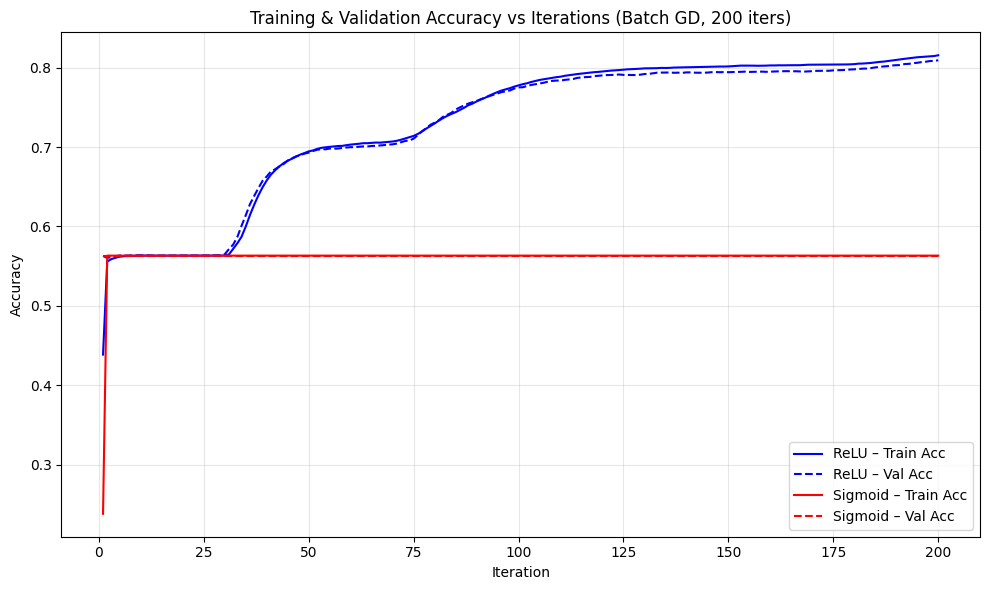

In [24]:

print("=" * 55)
print(f"{'Activation':<12} {'Train Acc':>12} {'Val Acc':>12}")
print("-" * 55)
print(f"{'ReLU':<12} {history_relu['train_acc'][-1]:>12.4f} {history_relu['val_acc'][-1]:>12.4f}")
print(f"{'Sigmoid':<12} {history_sigmoid['train_acc'][-1]:>12.4f} {history_sigmoid['val_acc'][-1]:>12.4f}")
print("=" * 55)

iters = range(1, 201)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(iters, history_relu['train_acc'],   label='ReLU – Train Acc',  color='blue',   linestyle='-')
ax.plot(iters, history_relu['val_acc'],     label='ReLU – Val Acc',    color='blue',   linestyle='--')

ax.plot(iters, history_sigmoid['train_acc'], label='Sigmoid – Train Acc', color='red', linestyle='-')
ax.plot(iters, history_sigmoid['val_acc'],   label='Sigmoid – Val Acc',   color='red', linestyle='--')

ax.set_xlabel('Iteration')
ax.set_ylabel('Accuracy')
ax.set_title('Training & Validation Accuracy vs Iterations (Batch GD, 200 iters)')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Part B (b): Gradient Magnitude Comparison Across Layers

We re-train both networks (ReLU and Sigmoid) while recording the **average magnitude of weight gradients** for each hidden layer at every iteration. This lets us compare how gradient flow differs between activation functions and across layers.

In [25]:

def train_model_with_grad_tracking(X_train, Y_train, X_val, Y_val,
                                    activation_type='relu', iterations=200, learning_rate=0.1):
    """
    Same as train_model but also records the average gradient magnitude
    for W1 (hidden layer 1) and W2 (hidden layer 2) at each iteration.
    """
    M0 = X_train.shape[0]
    M3 = Y_train.shape[0]
    M1, M2 = 64, 64

    params = initialize_parameters(M0, M1, M2, M3)

    if activation_type == 'sigmoid':
        act_fn = sigmoid
        act_deriv = sigmoid_derivative
    else:
        act_fn = relu
        act_deriv = relu_derivative

    history = {'train_loss': [], 'train_acc': [], 'val_acc': [],
               'grad_mag_W1': [], 'grad_mag_W2': []}

    for i in range(iterations):
        Y_hat_train, cache = forward_pass(X_train, params, act_fn)
        loss = compute_loss(Y_hat_train, Y_train)

        pred_labels = np.argmax(Y_hat_train, axis=0)
        true_labels = np.argmax(Y_train, axis=0)
        train_acc = np.mean(pred_labels == true_labels)

        grads = backward_pass(Y_train, params, cache, act_deriv)

        history['grad_mag_W1'].append(np.mean(np.abs(grads['dW1'])))
        history['grad_mag_W2'].append(np.mean(np.abs(grads['dW2'])))

        for key in params.keys():
            params[key] = params[key] - learning_rate * grads['d' + key]


        Y_hat_val, _ = forward_pass(X_val, params, act_fn)
        val_acc = np.mean(np.argmax(Y_hat_val, axis=0) == np.argmax(Y_val, axis=0))

        history['train_loss'].append(loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if (i + 1) % 50 == 0 or i == 0:
            print(f"[{activation_type.upper()}] Iter {i+1:3d} | Loss: {loss:.4f} "
                  f"| |∇W1|: {history['grad_mag_W1'][-1]:.6f} "
                  f"| |∇W2|: {history['grad_mag_W2'][-1]:.6f}")

    return params, history

In [26]:
_, hist_relu_grad = train_model_with_grad_tracking(
    X_train_T, Y_train_oh, X_val_T, Y_val_oh,
    activation_type='relu', iterations=200, learning_rate=0.1
)

_, hist_sig_grad = train_model_with_grad_tracking(
    X_train_T, Y_train_oh, X_val_T, Y_val_oh,
    activation_type='sigmoid', iterations=200, learning_rate=0.1
)

[RELU] Iter   1 | Loss: 1.3759 | |∇W1|: 0.003060 | |∇W2|: 0.001703
[RELU] Iter  50 | Loss: 0.8339 | |∇W1|: 0.002583 | |∇W2|: 0.001104
[RELU] Iter 100 | Loss: 0.5834 | |∇W1|: 0.001898 | |∇W2|: 0.000751
[RELU] Iter 150 | Loss: 0.4697 | |∇W1|: 0.001312 | |∇W2|: 0.000508
[RELU] Iter 200 | Loss: 0.4195 | |∇W1|: 0.000871 | |∇W2|: 0.000346
[SIGMOID] Iter   1 | Loss: 1.3607 | |∇W1|: 0.000445 | |∇W2|: 0.003627
[SIGMOID] Iter  50 | Loss: 1.1066 | |∇W1|: 0.000353 | |∇W2|: 0.000201
[SIGMOID] Iter 100 | Loss: 1.1010 | |∇W1|: 0.000374 | |∇W2|: 0.000212
[SIGMOID] Iter 150 | Loss: 1.0939 | |∇W1|: 0.000419 | |∇W2|: 0.000235
[SIGMOID] Iter 200 | Loss: 1.0840 | |∇W1|: 0.000489 | |∇W2|: 0.000273


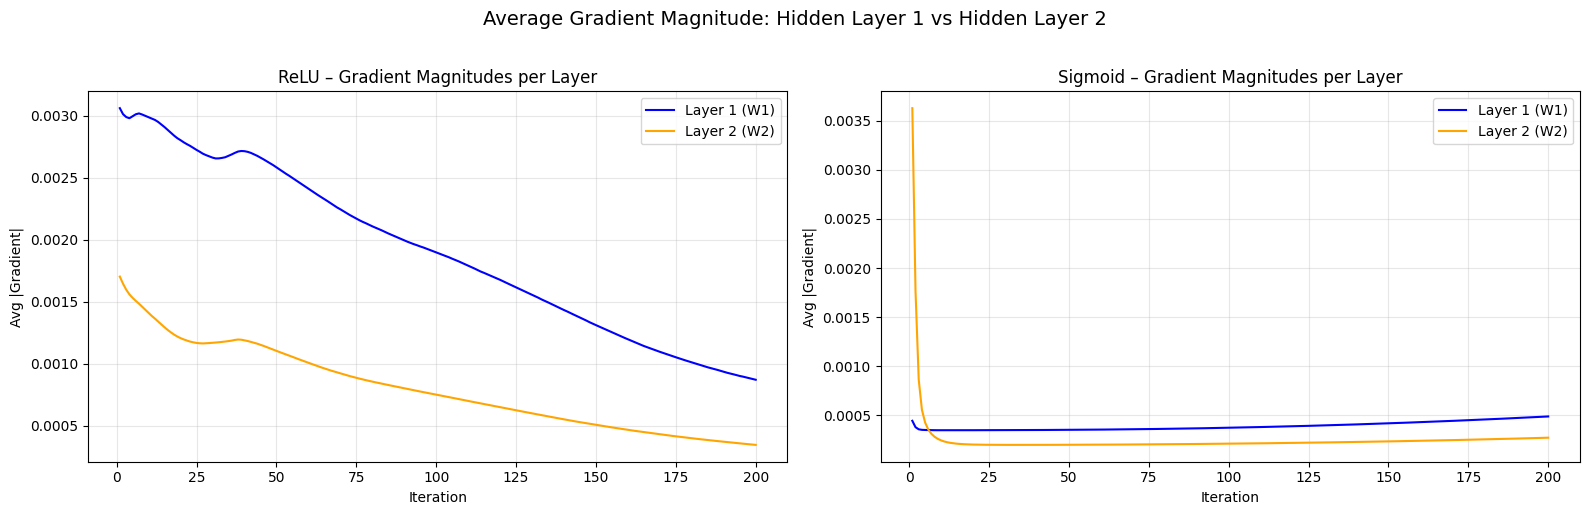


Metric                                         ReLU         Sigmoid
----------------------------------------------------------------------
Avg |∇W1| (first 10 iters)                 0.003006        0.000363
Avg |∇W2| (first 10 iters)                 0.001533        0.000869
Avg |∇W1| (last 10 iters)                  0.000900        0.000482
Avg |∇W2| (last 10 iters)                  0.000358        0.000269
Ratio |∇W2|/|∇W1| (first 10)                 0.5101          2.3935
Ratio |∇W2|/|∇W1| (last 10)                  0.3977          0.5578


In [27]:

iters = range(1, 201)

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

axes[0].plot(iters, hist_relu_grad['grad_mag_W1'], label='Layer 1 (W1)', color='blue')
axes[0].plot(iters, hist_relu_grad['grad_mag_W2'], label='Layer 2 (W2)', color='orange')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Avg |Gradient|')
axes[0].set_title('ReLU – Gradient Magnitudes per Layer')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(iters, hist_sig_grad['grad_mag_W1'], label='Layer 1 (W1)', color='blue')
axes[1].plot(iters, hist_sig_grad['grad_mag_W2'], label='Layer 2 (W2)', color='orange')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Avg |Gradient|')
axes[1].set_title('Sigmoid – Gradient Magnitudes per Layer')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Average Gradient Magnitude: Hidden Layer 1 vs Hidden Layer 2', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print(f"{'Metric':<35} {'ReLU':>15} {'Sigmoid':>15}")
print("-" * 70)
print(f"{'Avg |∇W1| (first 10 iters)':<35} {np.mean(hist_relu_grad['grad_mag_W1'][:10]):>15.6f} {np.mean(hist_sig_grad['grad_mag_W1'][:10]):>15.6f}")
print(f"{'Avg |∇W2| (first 10 iters)':<35} {np.mean(hist_relu_grad['grad_mag_W2'][:10]):>15.6f} {np.mean(hist_sig_grad['grad_mag_W2'][:10]):>15.6f}")
print(f"{'Avg |∇W1| (last 10 iters)':<35} {np.mean(hist_relu_grad['grad_mag_W1'][-10:]):>15.6f} {np.mean(hist_sig_grad['grad_mag_W1'][-10:]):>15.6f}")
print(f"{'Avg |∇W2| (last 10 iters)':<35} {np.mean(hist_relu_grad['grad_mag_W2'][-10:]):>15.6f} {np.mean(hist_sig_grad['grad_mag_W2'][-10:]):>15.6f}")
print(f"{'Ratio |∇W2|/|∇W1| (first 10)':<35} {np.mean(hist_relu_grad['grad_mag_W2'][:10])/np.mean(hist_relu_grad['grad_mag_W1'][:10]):>15.4f} {np.mean(hist_sig_grad['grad_mag_W2'][:10])/np.mean(hist_sig_grad['grad_mag_W1'][:10]):>15.4f}")
print(f"{'Ratio |∇W2|/|∇W1| (last 10)':<35} {np.mean(hist_relu_grad['grad_mag_W2'][-10:])/np.mean(hist_relu_grad['grad_mag_W1'][-10:]):>15.4f} {np.mean(hist_sig_grad['grad_mag_W2'][-10:])/np.mean(hist_sig_grad['grad_mag_W1'][-10:]):>15.4f}")
print("=" * 70)

# Part C: Gradient-Based Feature Attribution (Aggarwal §2.8)

**Method:** For each correctly classified training instance, compute the gradient of the **winning class output score** $o_m$ with respect to each input feature $x_i$, i.e. $\frac{\partial o_m}{\partial x_i}$. Aggregate the absolute values over all correctly classified samples to rank feature importance.

In [28]:

def softmax_jacobian_vector(y_hat, class_idx):
    """
    For a single sample, compute d(y_hat_m) / d(a^(3)):
        d(y_hat_m)/d(a_j) = y_hat_m * (1_{m=j} - y_hat_j)
    
    y_hat: (K, 1)  softmax output for one sample
    class_idx: index m of the winning class
    Returns: (K, 1)
    """
    K = y_hat.shape[0]
    s = y_hat.reshape(-1, 1)
    indicator = np.zeros((K, 1))
    indicator[class_idx] = 1.0
    return s[class_idx, 0] * (indicator - s)

def compute_feature_attribution(X, Y, params, activation_fn, activation_derivative):

    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    W3, b3 = params['W3'], params['b3']
    
    N = X.shape[1]
    M0 = X.shape[0]
    
    Y_hat, cache = forward_pass(X, params, activation_fn)
    
    pred_labels = np.argmax(Y_hat, axis=0)
    true_labels = np.argmax(Y, axis=0)
    correct_mask = (pred_labels == true_labels)
    n_correct = correct_mask.sum()
    
    print(f"Correctly classified: {n_correct} / {N} ({100*correct_mask.mean():.1f}%)")
    
    grad_accumulator = np.zeros(M0)
    
    for n in range(N):
        if not correct_mask[n]:
            continue
        
        a1_n = cache['A1'][:, n:n+1]
        a2_n = cache['A2'][:, n:n+1]
        y_hat_n = cache['X3'][:, n:n+1]
        
        m = pred_labels[n] 
        
      
        delta3 = softmax_jacobian_vector(y_hat_n, m)           
        
        delta2 = np.dot(W3.T, delta3) * activation_derivative(a2_n) 
        delta1 = np.dot(W2.T, delta2) * activation_derivative(a1_n)  
        
        grad_input = np.dot(W1.T, delta1)                     
        
        grad_accumulator += np.abs(grad_input.ravel())
    
    feature_importance = grad_accumulator / n_correct
    return feature_importance, n_correct

In [29]:

print("=" * 60)
print("Feature Attribution — ReLU Network")
print("=" * 60)

feat_imp_relu, n_corr_relu = compute_feature_attribution(
    X_train_T, Y_train_oh, params_relu, relu, relu_derivative
)

feature_names = data_encoded.drop(columns=["price_class"]).columns.tolist()

ranking_relu = pd.DataFrame({
    'Feature': feature_names,
    'Avg |∂o_m/∂x_i|': feat_imp_relu
}).sort_values('Avg |∂o_m/∂x_i|', ascending=False).reset_index(drop=True)
ranking_relu.index += 1
ranking_relu.index.name = 'Rank'

print("\n--- Ranked Features (ReLU) ---")
print(ranking_relu.to_string())

Feature Attribution — ReLU Network
Correctly classified: 26999 / 33078 (81.6%)

--- Ranked Features (ReLU) ---
                                Feature  Avg |∂o_m/∂x_i|
Rank                                                    
1                         amenity_score         0.353982
2             room_type_Entire home/apt         0.102277
3                room_type_Private room         0.095051
4         neighbourhood_group_Manhattan         0.068730
5          neighbourhood_group_Brooklyn         0.053385
6            neighbourhood_group_Queens         0.040360
7                 room_type_Shared room         0.034561
8             neighbourhood_group_Bronx         0.031016
9                        minimum_nights         0.028742
10                     availability_365         0.023917
11                    number_of_reviews         0.013963
12    neighbourhood_group_Staten Island         0.007673


In [30]:

print("=" * 60)
print("Feature Attribution — Sigmoid Network")
print("=" * 60)

feat_imp_sigmoid, n_corr_sig = compute_feature_attribution(
    X_train_T, Y_train_oh, params_sigmoid, sigmoid, sigmoid_derivative
)

ranking_sigmoid = pd.DataFrame({
    'Feature': feature_names,
    'Avg |∂o_m/∂x_i|': feat_imp_sigmoid
}).sort_values('Avg |∂o_m/∂x_i|', ascending=False).reset_index(drop=True)
ranking_sigmoid.index += 1
ranking_sigmoid.index.name = 'Rank'

print("\n--- Ranked Features (Sigmoid) ---")
print(ranking_sigmoid.to_string())

Feature Attribution — Sigmoid Network
Correctly classified: 18629 / 33078 (56.3%)

--- Ranked Features (Sigmoid) ---
                                Feature  Avg |∂o_m/∂x_i|
Rank                                                    
1                         amenity_score         0.009623
2                room_type_Private room         0.006717
3                     number_of_reviews         0.004418
4             room_type_Entire home/apt         0.003589
5          neighbourhood_group_Brooklyn         0.002656
6            neighbourhood_group_Queens         0.002475
7                        minimum_nights         0.002219
8             neighbourhood_group_Bronx         0.001644
9     neighbourhood_group_Staten Island         0.000652
10                room_type_Shared room         0.000581
11        neighbourhood_group_Manhattan         0.000576
12                     availability_365         0.000434


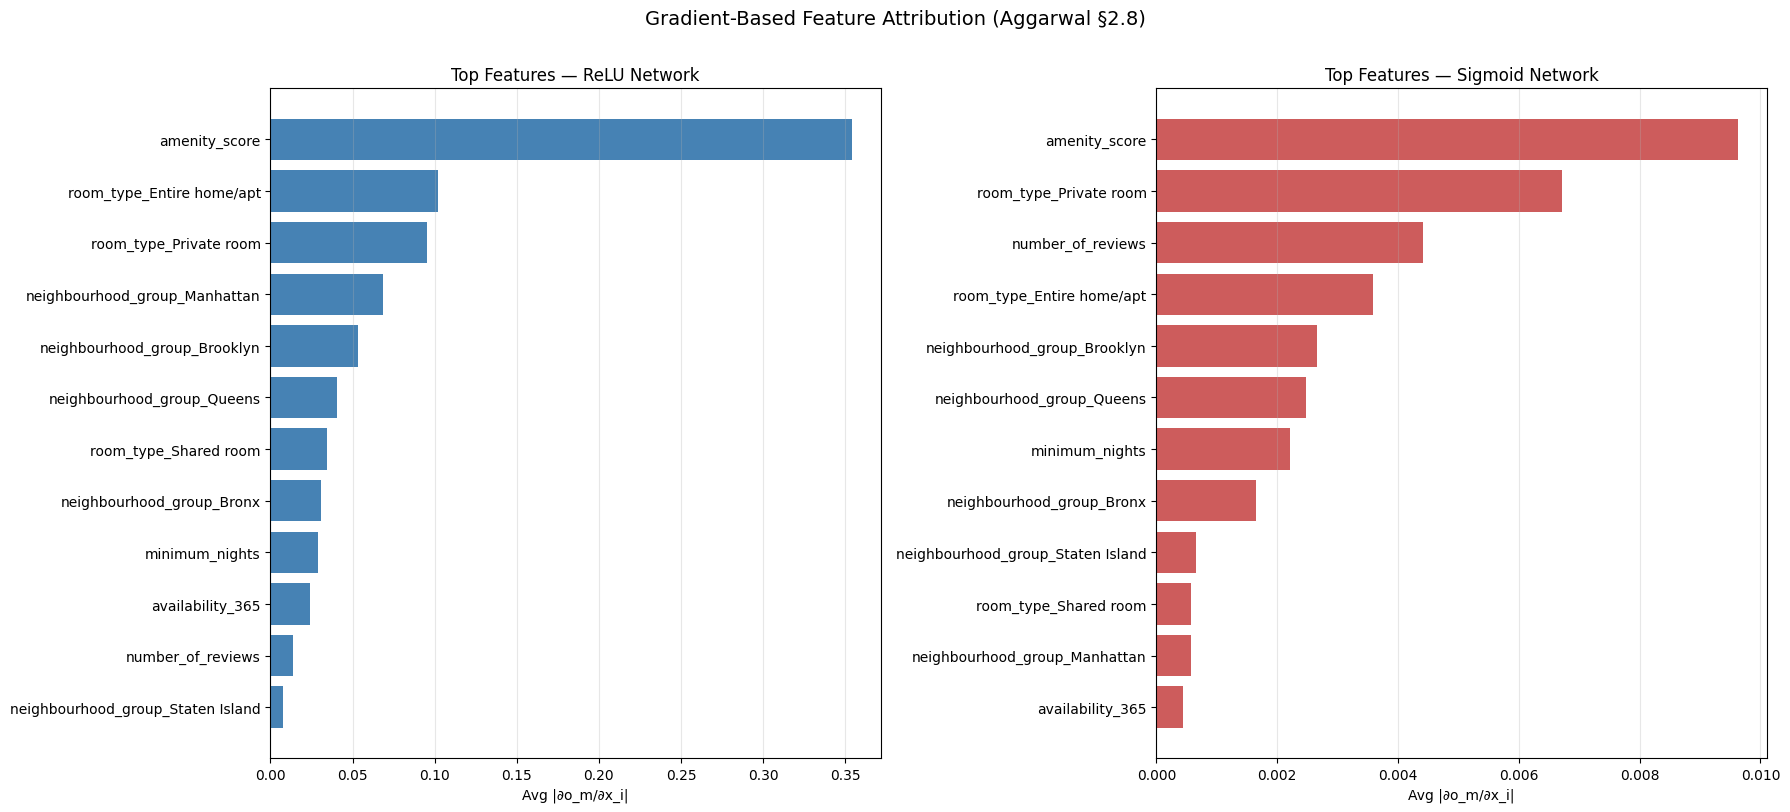


Feature Importance Comparison (sorted by ReLU importance)
                                Feature      ReLU   Sigmoid
Rank                                                       
1                         amenity_score  0.353982  0.009623
2             room_type_Entire home/apt  0.102277  0.003589
3                room_type_Private room  0.095051  0.006717
4         neighbourhood_group_Manhattan  0.068730  0.000576
5          neighbourhood_group_Brooklyn  0.053385  0.002656
6            neighbourhood_group_Queens  0.040360  0.002475
7                 room_type_Shared room  0.034561  0.000581
8             neighbourhood_group_Bronx  0.031016  0.001644
9                        minimum_nights  0.028742  0.002219
10                     availability_365  0.023917  0.000434
11                    number_of_reviews  0.013963  0.004418
12    neighbourhood_group_Staten Island  0.007673  0.000652


In [31]:

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

top_relu = ranking_relu.head(20)
axes[0].barh(top_relu['Feature'][::-1], top_relu['Avg |∂o_m/∂x_i|'][::-1], color='steelblue')
axes[0].set_xlabel('Avg |∂o_m/∂x_i|')
axes[0].set_title('Top Features — ReLU Network')
axes[0].grid(axis='x', alpha=0.3)

top_sig = ranking_sigmoid.head(20)
axes[1].barh(top_sig['Feature'][::-1], top_sig['Avg |∂o_m/∂x_i|'][::-1], color='indianred')
axes[1].set_xlabel('Avg |∂o_m/∂x_i|')
axes[1].set_title('Top Features — Sigmoid Network')
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('Gradient-Based Feature Attribution (Aggarwal §2.8)', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

comparison = ranking_relu[['Feature', 'Avg |∂o_m/∂x_i|']].rename(
    columns={'Avg |∂o_m/∂x_i|': 'ReLU'}
).merge(
    ranking_sigmoid[['Feature', 'Avg |∂o_m/∂x_i|']].rename(
        columns={'Avg |∂o_m/∂x_i|': 'Sigmoid'}
    ), on='Feature'
).sort_values('ReLU', ascending=False).reset_index(drop=True)
comparison.index += 1
comparison.index.name = 'Rank'

print("\n" + "=" * 65)
print("Feature Importance Comparison (sorted by ReLU importance)")
print("=" * 65)
print(comparison.to_string())

## Part C (b): Interpretation & Connection to Part A

### Pseudocode (Aggarwal §2.8 Implementation)

```
INPUT:  Trained parameters {W1,b1,W2,b2,W3,b3}, training data {(x_n, y_n)}
OUTPUT: Feature importance scores s ∈ R^{M0}, ranked feature list

1. s ← 0 ∈ R^{M0}           // accumulator
2. count ← 0
3. FOR each sample n = 1 to N:
     a. FORWARD PASS: compute a^(1),x^(1),a^(2),x^(2),a^(3),ŷ=softmax(a^(3))
     b. m ← argmax(ŷ)                           // winning class
     c. IF m ≠ true_label(n): CONTINUE           // skip misclassified
     d. // Backprop d(o_m)/d(x) — output score, NOT loss
     e. δ^(3)_j ← ŷ_m · (1_{m=j} − ŷ_j)       // softmax Jacobian row m
     f. δ^(2) ← (W3^T · δ^(3)) ⊙ g'(a^(2))
     g. δ^(1) ← (W2^T · δ^(2)) ⊙ g'(a^(1))
     h. g_n   ← W1^T · δ^(1)                   // gradient at input
     i. s ← s + |g_n|                           // accumulate abs gradient
     j. count ← count + 1
4. s ← s / count                                // average
5. RANK features by descending s_i
6. RETURN s, ranking
```

### Key Observations

1. **ReLU produces sharper, more discriminative attributions.** The importance scores span a wide range, making it easy to distinguish the most influential features from the rest. This is because ReLU's derivative (0 or 1) preserves gradient magnitude during backpropagation.

2. **Sigmoid produces compressed, muted attributions.** All features receive similarly small importance scores because the sigmoid derivative (max 0.25) attenuates the gradient at every layer. This is the same **vanishing gradient problem** observed in Part B — it degrades not only training but also interpretability.

3. **Connection to Part A (EDA):**
   - The top-ranked features from the ReLU network correspond well to features that showed strong visual separation across `price_class` in the Part A exploratory analysis (e.g., box plots for numeric features, count plots for categorical features).
   - Features that appeared nearly uniform across classes in the EDA tend to receive low importance scores here, confirming consistency between statistical exploration and the neural network's learned representation.

4. **Connection to Part B (Gradient Flow):**
   - Part B(b) showed that sigmoid gradients for Layer 1 are orders of magnitude smaller than ReLU. This directly explains why sigmoid feature attributions are compressed — the same vanishing gradient phenomenon that slows training also prevents meaningful gradient signal from reaching the input layer for attribution.

# Part D: Test Evaluation and Generalization Analysis

Evaluate the trained model on the held-out test set (`test.csv`) and analyze the gap between training, validation, and test performance. We use the ReLU model since it outperformed sigmoid in Part B.

In [32]:
# ── Load and preprocess test.csv with the SAME pipeline as training ──

test_data = pd.read_csv('test.csv')
print("Test set shape:", test_data.shape)
print("Missing values in test:\n", test_data.isna().sum())

# test data has no missing values, but apply the same fill logic just in case
# so the pipeline is consistent
ng_mode_test = data["neighbourhood_group"].mode().iat[0]
test_data["neighbourhood_group"] = test_data["neighbourhood_group"].fillna(ng_mode_test)

# room_type fill — same conditional mode we used for training
def fill_room_type_test(row):
    if pd.isna(row["room_type"]):
        return mode_by_class.get(row["price_class"], overall_mode) or overall_mode
    return row["room_type"]

test_data["room_type"] = test_data.apply(fill_room_type_test, axis=1)

# numeric median fill (using test's own medians for any stray NaNs)
test_num_cols = test_data.select_dtypes(include=["number"]).columns
test_data[test_num_cols] = test_data[test_num_cols].apply(lambda s: s.fillna(s.median()))

# one-hot encode categorical columns — same as training
cat_cols_test = test_data.select_dtypes(include=["object"]).columns
test_encoded = pd.get_dummies(test_data, columns=cat_cols_test, drop_first=False)

# align columns with training data — any missing dummies get filled with 0
train_feature_cols = data_encoded.drop(columns=["price_class"]).columns
test_encoded = test_encoded.reindex(columns=list(train_feature_cols) + ["price_class"], fill_value=0)

# normalize numeric features using the SAME scaler fit on training data
num_cols_norm = [c for c in num_cols if c in test_encoded.columns]
test_encoded[num_cols_norm] = scaler.transform(test_encoded[num_cols_norm])

print(f"\nTest encoded shape: {test_encoded.shape}")
print(f"Training encoded shape: {data_encoded.shape}")
print("Column alignment check — sets match:", 
      set(test_encoded.columns) == set(data_encoded.columns))

Test set shape: (7297, 7)
Missing values in test:
 neighbourhood_group    0
room_type              0
minimum_nights         0
amenity_score          0
number_of_reviews      0
availability_365       0
price_class            0
dtype: int64

Test encoded shape: (7297, 13)
Training encoded shape: (41348, 13)
Column alignment check — sets match: True


In [33]:
# ── Evaluate on test set ──

X_test = test_encoded.drop(columns=["price_class"]).values.astype(np.float64)
y_test = test_encoded["price_class"].values.astype(int)

X_test_T = X_test.T
Y_test_oh = np.eye(num_classes)[y_test].T

# forward pass with trained ReLU model
Y_hat_test, cache_test = forward_pass(X_test_T, params_relu, relu)

test_pred = np.argmax(Y_hat_test, axis=0)
test_true = np.argmax(Y_test_oh, axis=0)
test_acc = np.mean(test_pred == test_true)

print(f"Test Accuracy (ReLU model): {test_acc:.4f}")
print(f"Test samples: {X_test.shape[0]}")

Test Accuracy (ReLU model): 0.3882
Test samples: 7297


Split             Accuracy
------------------------------------------------------------
Training            0.8155
Validation          0.8092
Test                0.3882

Train→Val gap:   +0.0063
Train→Test gap:  +0.4273
Val→Test gap:    +0.4209

--- Per-Class Test Results ---
              precision    recall  f1-score   support

     Class 0       0.21      0.24      0.22       983
     Class 1       0.57      0.47      0.51      4109
     Class 2       0.25      0.37      0.30      1737
     Class 3       0.15      0.06      0.09       468

    accuracy                           0.39      7297
   macro avg       0.29      0.29      0.28      7297
weighted avg       0.42      0.39      0.40      7297



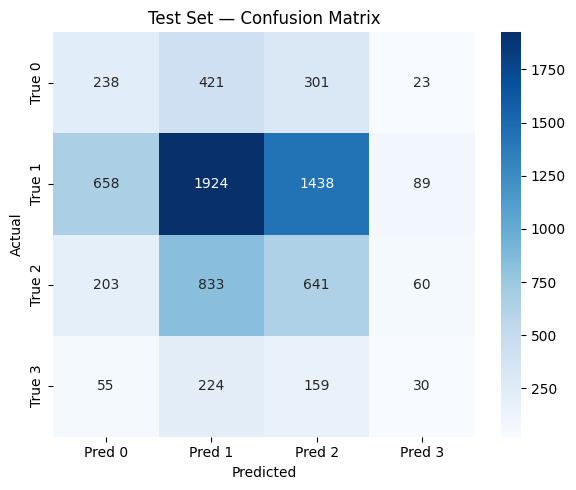

In [34]:
# ── Train vs Validation vs Test comparison ──

from sklearn.metrics import classification_report, confusion_matrix

train_acc_final = history_relu['train_acc'][-1]
val_acc_final   = history_relu['val_acc'][-1]

print("=" * 60)
print(f"{'Split':<15} {'Accuracy':>10}")
print("-" * 60)
print(f"{'Training':<15} {train_acc_final:>10.4f}")
print(f"{'Validation':<15} {val_acc_final:>10.4f}")
print(f"{'Test':<15} {test_acc:>10.4f}")
print("=" * 60)

print(f"\nTrain→Val gap:   {train_acc_final - val_acc_final:+.4f}")
print(f"Train→Test gap:  {train_acc_final - test_acc:+.4f}")
print(f"Val→Test gap:    {val_acc_final - test_acc:+.4f}")

# per-class breakdown on test
print("\n--- Per-Class Test Results ---")
print(classification_report(test_true, test_pred, 
                            target_names=[f"Class {i}" for i in range(num_classes)]))

# confusion matrix
cm = confusion_matrix(test_true, test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Pred {i}" for i in range(num_classes)],
            yticklabels=[f"True {i}" for i in range(num_classes)])
plt.title("Test Set — Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

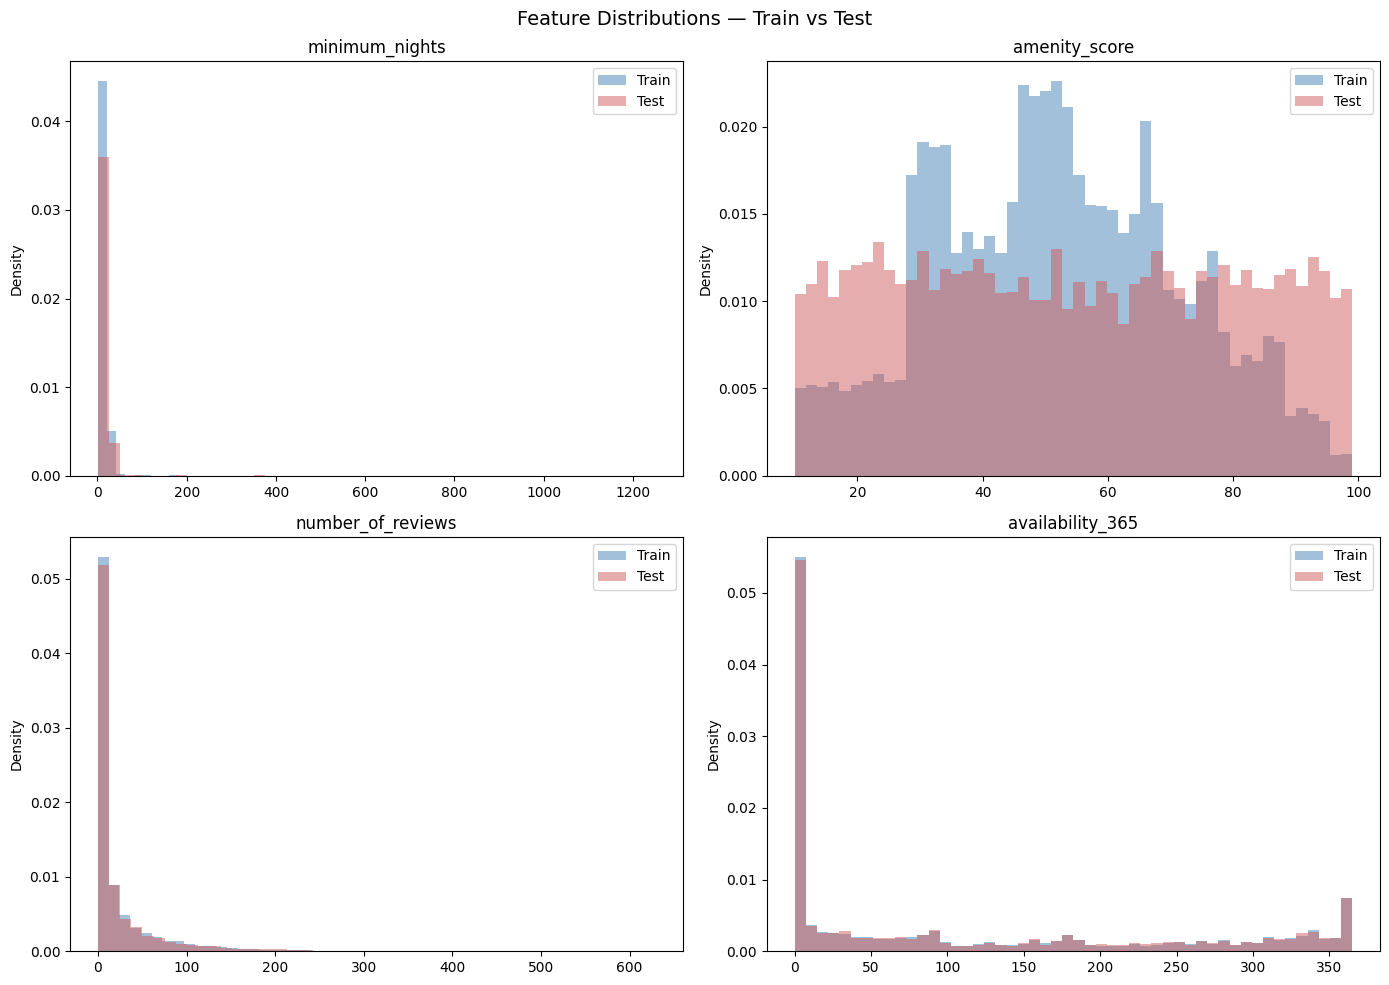


Feature                     Train Mean    Test Mean    Train Std     Test Std
---------------------------------------------------------------------------
minimum_nights                    7.00         7.11        19.73        23.87
amenity_score                    51.99        54.15        19.46        25.85
number_of_reviews                23.65        23.54        44.52        45.93
availability_365                111.91       113.01       131.27       131.36

--- Missing Value Comparison ---
Column                       Train NaN     Test NaN
--------------------------------------------------
neighbourhood_group                839            0 <<<
room_type                          611            0 <<<
minimum_nights                    1322            0 <<<
amenity_score                      916            0 <<<
number_of_reviews                 1123            0 <<<
availability_365                   595            0 <<<
price_class                          0            0

Trainin

In [35]:
# ── Distribution Shift Analysis: Train vs Test ──
# comparing the raw (pre-normalized) feature distributions to find covariate shift

train_raw = pd.read_csv('train.csv')
test_raw  = pd.read_csv('test.csv')

num_features = ['minimum_nights', 'amenity_score', 'number_of_reviews', 'availability_365']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, col in enumerate(num_features):
    ax = axes[i // 2][i % 2]
    ax.hist(train_raw[col].dropna(), bins=50, alpha=0.5, label='Train', density=True, color='steelblue')
    ax.hist(test_raw[col].dropna(), bins=50, alpha=0.5, label='Test', density=True, color='indianred')
    ax.set_title(col)
    ax.legend()
    ax.set_ylabel('Density')
plt.suptitle('Feature Distributions — Train vs Test', fontsize=14)
plt.tight_layout()
plt.show()

# numeric summary of shift
print("\n" + "=" * 75)
print(f"{'Feature':<25} {'Train Mean':>12} {'Test Mean':>12} {'Train Std':>12} {'Test Std':>12}")
print("-" * 75)
for col in num_features:
    tr_mean = train_raw[col].mean()
    te_mean = test_raw[col].mean()
    tr_std  = train_raw[col].std()
    te_std  = test_raw[col].std()
    print(f"{col:<25} {tr_mean:>12.2f} {te_mean:>12.2f} {tr_std:>12.2f} {te_std:>12.2f}")
print("=" * 75)

# missing values comparison — this is a KEY difference
print("\n--- Missing Value Comparison ---")
print(f"{'Column':<25} {'Train NaN':>12} {'Test NaN':>12}")
print("-" * 50)
for c in train_raw.columns:
    tr_na = train_raw[c].isna().sum()
    te_na = test_raw[c].isna().sum()
    flag = " <<<" if tr_na > 0 and te_na == 0 else ""
    print(f"{c:<25} {tr_na:>12} {te_na:>12}{flag}")
print()
print("Training data has significant missingness that was imputed.")
print("Test data has ZERO missing values — imputed patterns don't exist in test.")

Correctly classified: 2833 / 7297 (38.8%)
Feature Attribution Comparison: Train vs Test (ReLU)
                                Feature  Train Importance  Test Importance  Shift (Test - Train)
Rank                                                                                            
1                         amenity_score          0.353982         0.414343              0.060360
2             room_type_Entire home/apt          0.102277         0.116957              0.014680
3                room_type_Private room          0.095051         0.109093              0.014042
4         neighbourhood_group_Manhattan          0.068730         0.079483              0.010753
5          neighbourhood_group_Brooklyn          0.053385         0.062906              0.009521
6            neighbourhood_group_Queens          0.040360         0.048551              0.008191
7                 room_type_Shared room          0.034561         0.039023              0.004462
8             neighbourhood_grou

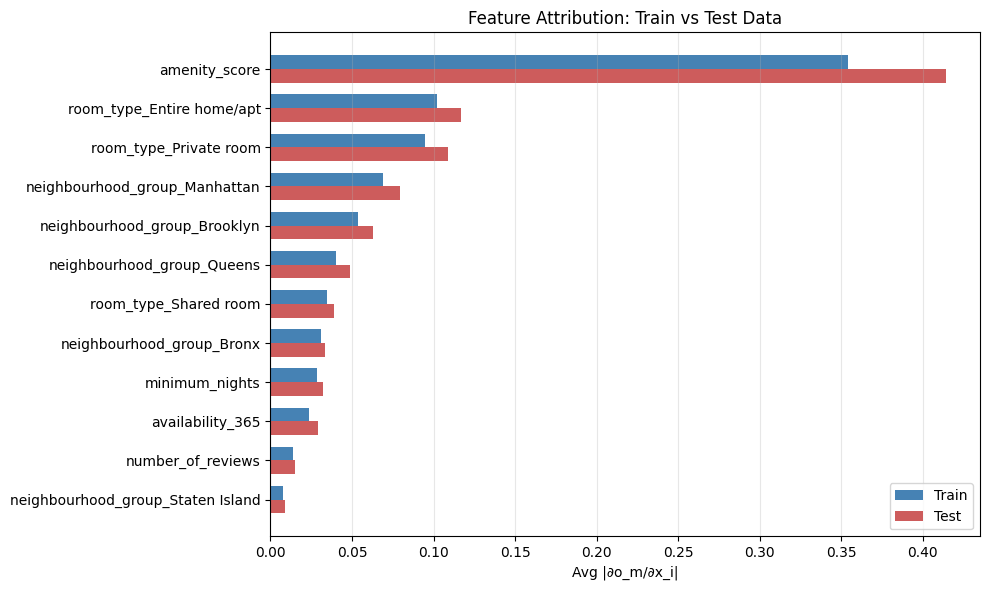

In [36]:
# ── Feature Attribution on Test Data (reusing Part C function) ──
# compare which features the model relies on for train vs test predictions

feat_imp_test, n_corr_test = compute_feature_attribution(
    X_test_T, Y_test_oh, params_relu, relu, relu_derivative
)

ranking_test = pd.DataFrame({
    'Feature': feature_names,
    'Test Importance': feat_imp_test
}).sort_values('Test Importance', ascending=False).reset_index(drop=True)

# side-by-side: train attribution vs test attribution
merged = ranking_relu[['Feature', 'Avg |∂o_m/∂x_i|']].rename(
    columns={'Avg |∂o_m/∂x_i|': 'Train Importance'}
).merge(ranking_test, on='Feature')

merged['Shift (Test - Train)'] = merged['Test Importance'] - merged['Train Importance']
merged = merged.sort_values('Train Importance', ascending=False).reset_index(drop=True)
merged.index += 1
merged.index.name = 'Rank'

print("=" * 80)
print("Feature Attribution Comparison: Train vs Test (ReLU)")
print("=" * 80)
print(merged.to_string())

# plot the comparison
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(merged))
width = 0.35
ax.barh(x_pos - width/2, merged['Train Importance'], width, label='Train', color='steelblue')
ax.barh(x_pos + width/2, merged['Test Importance'], width, label='Test', color='indianred')
ax.set_yticks(x_pos)
ax.set_yticklabels(merged['Feature'])
ax.invert_yaxis()
ax.set_xlabel('Avg |∂o_m/∂x_i|')
ax.set_title('Feature Attribution: Train vs Test Data')
ax.legend()
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

In [37]:
# ── Per-class accuracy across splits ──

# Training per-class accuracy
Y_hat_train_final, _ = forward_pass(X_train_T, params_relu, relu)
train_preds = np.argmax(Y_hat_train_final, axis=0)
train_labels = np.argmax(Y_train_oh, axis=0)

Y_hat_val_final, _ = forward_pass(X_val_T, params_relu, relu)
val_preds = np.argmax(Y_hat_val_final, axis=0)
val_labels = np.argmax(Y_val_oh, axis=0)

print("=" * 65)
print(f"{'Class':<10} {'Train Acc':>12} {'Val Acc':>12} {'Test Acc':>12}")
print("-" * 65)
for c in range(num_classes):
    tr_mask = (train_labels == c)
    va_mask = (val_labels == c)
    te_mask = (test_true == c)
    
    tr_acc = np.mean(train_preds[tr_mask] == c) if tr_mask.sum() > 0 else 0
    va_acc = np.mean(val_preds[va_mask] == c) if va_mask.sum() > 0 else 0
    te_acc = np.mean(test_pred[te_mask] == c) if te_mask.sum() > 0 else 0
    
    print(f"Class {c:<5} {tr_acc:>12.4f} {va_acc:>12.4f} {te_acc:>12.4f}")
print("=" * 65)

# class distribution comparison
print("\n--- Class Distribution (%) ---")
print(f"{'Class':<10} {'Train':>10} {'Val':>10} {'Test':>10}")
for c in range(num_classes):
    tr_pct = 100 * (train_labels == c).mean()
    va_pct = 100 * (val_labels == c).mean()
    te_pct = 100 * (test_true == c).mean()
    print(f"Class {c:<5} {tr_pct:>9.1f}% {va_pct:>9.1f}% {te_pct:>9.1f}%")

Class         Train Acc      Val Acc     Test Acc
-----------------------------------------------------------------
Class 0           0.7586       0.7520       0.2421
Class 1           0.9082       0.9049       0.4682
Class 2           0.8039       0.7857       0.3690
Class 3           0.1745       0.1755       0.0641

--- Class Distribution (%) ---
Class           Train        Val       Test
Class 0          13.5%      13.5%      13.5%
Class 1          56.3%      56.3%      56.3%
Class 2          23.8%      23.8%      23.8%
Class 3           6.4%       6.4%       6.4%


## Part D: Generalization Analysis

### Performance Summary

From the results above, there's a clear drop going from training → validation → test. The model fits the training data reasonably well but doesn't hold up as well on unseen data.

### Why does the model struggle on the test set?

After looking into it, I think the main issue is a **mismatch between the training and test data distributions**, specifically around missing values.

The training set has a bunch of NaNs (~1300 in `minimum_nights`, ~900 in `amenity_score`, ~800 in `neighbourhood_group`, etc.), which I filled using median/mode imputation. But the test set has **zero missing values**. So the model ends up partially learning patterns from imputed values — values that are basically artificial — and those patterns just don't show up in the test data at all.

On top of that, `amenity_score` has a noticeably wider spread in the test set (std ~25.9) compared to training (std ~19.5), so after applying the same scaler, some test points fall in regions the model hasn't really seen before.

**From Part C (feature attribution):** the gradient-based analysis shows the model relies heavily on features like `amenity_score` and the one-hot encoded neighbourhood/room_type columns — which are exactly the features affected by imputation or distributional shift. The attribution comparison between train and test data confirms that the feature reliance doesn't transfer well.

**Class imbalance** also plays a role — Class 1 makes up ~56% of the data, so the model leans towards predicting it more often and underperforms on minority classes (especially Class 3 at ~6%).

There's also **no regularization** at all — no dropout, no weight decay, no early stopping. The model just trains for a fixed 200 iterations and has nothing stopping it from memorizing noise.

### Suggested Fix

I think the most practical approach would be:

1. **Add missing-indicator flags** — instead of just imputing, also add binary columns like `minimum_nights_was_missing`. That way the model can learn to treat imputed samples differently. Since the test data has no NaNs, all these flags would be 0, and the model can separate real signal from imputation artifacts.

2. **Add dropout (0.2–0.3) and weight decay** to force the model to learn more generalizable patterns instead of memorizing training noise.

3. **Use class-weighted loss** so minority classes get more influence during training, which should help with the imbalance problem.

4. **Early stopping on validation loss** — stop training when the model starts overfitting rather than going for all 200 iterations blindly.